In [1]:
import sys, os

path = "P:/Dokumente/3 Uni/SoSe21/Data_Compression/DataCompressionNew/DataCompression/exp/full_run/checkpoint_11/rl_agent.zip"

sys.path.append("P:/Dokumente/3 Uni/SoSe21/Data_Compression/DataCompressionNew")
sys.path.append(os.getcwd())
from DataCompression.src.buffer import Decoder_Buffer

from stable_baselines3 import PPO
import gym 
import time
import torch
from tqdm import tqdm
import numpy as np


In [ ]:
policy_kwargs = dict(
    features_extractor_kwargs=dict(features_dim=128))
env = gym.make("BreakoutNoFrameskip-v4")
t = PPO("CnnPolicy",env, policy_kwargs=policy_kwargs)
t.load(path);

In [2]:
def fill_buffer(samples=100, randomly=True, use_tqdm=True, start = 500, image_acceptance_prob=0.003):
    """Fills the buffer randomly

    Args:
        steps (int): Number of steps to take
        use_tqdm (bool): Add progress bar if True.
    """
    print(f"Filling buffer with {samples} samples")
    buffer = Decoder_Buffer([210, 160, 3], 128, samples, flatten=True)
    time.sleep(1) # to avoid printstream clashing with progressbar
    observation = env.reset()
    r = tqdm(range(samples)) if use_tqdm else range(samples)

    env_step = 0
    for i in r:
        while True:
            action = t.predict(observation)
            observation, reward, done, info = env.step(action)
            latent = torch.zeros(128)# t.policy.features_extractor(observation).detach() # make sure to detach the latents to not propagate back through rl agent in decoder training
            env_step += 1

            r = torch.rand(1)
            if (env_step >= start and env_step % 50 == 0) or r < image_acceptance_prob: # min 500 steps in then every 50th, otherwise just randomly in the meantime
                buffer_observation = torch.from_numpy(observation).float()
                buffer.add(buffer_observation, latent)
                break
            if done:
                observation = env.reset()
                env_step = 0
                continue

    env.close()
    return buffer

In [3]:
test_values = [(800, 1), (500, 0.0001), (500, 0.003), (500, 0), (800, 0.003)]

In [4]:
for start, prob in test_values:
    test_buffer = fill_buffer(3000, start=start, image_acceptance_prob=prob)
    buffer_path = f"P:/Dokumente/3 Uni/SoSe21/Data_Compression/DataCompressionNew/DataCompression/exp/new_test_dataset/start{start}_prob{prob}/"
    test_buffer.save(buffer_path)


Filling buffer with 3000 samples
Created a buffer for images of shape torch.Size([3000, 100800]) and latents torch.Size([3000, 128])


100%|██████████| 3000/3000 [00:18<00:00, 164.48it/s]


Filling buffer with 3000 samples
Created a buffer for images of shape torch.Size([3000, 100800]) and latents torch.Size([3000, 128])


100%|██████████| 3000/3000 [36:08<00:00,  1.38it/s]


Filling buffer with 3000 samples
Created a buffer for images of shape torch.Size([3000, 100800]) and latents torch.Size([3000, 128])


100%|██████████| 3000/3000 [24:15<00:00,  2.06it/s]


Filling buffer with 3000 samples
Created a buffer for images of shape torch.Size([3000, 100800]) and latents torch.Size([3000, 128])


100%|██████████| 3000/3000 [32:13<00:00,  1.55it/s]


Filling buffer with 3000 samples
Created a buffer for images of shape torch.Size([3000, 100800]) and latents torch.Size([3000, 128])


100%|██████████| 3000/3000 [44:59<00:00,  1.11it/s]


In [ ]:
####################################################################################

In [2]:
test_buffer = Decoder_Buffer([210, 160, 3], 128, 3000, flatten=True)
buffer_path = "P:/Dokumente/3 Uni/SoSe21/Data_Compression/DataCompressionNew/DataCompression/exp/new_test_dataset/test_buffer"
test_buffer.load(buffer_path)

Created a buffer for images of shape torch.Size([3000, 100800]) and latents torch.Size([3000, 128])


In [3]:
from matplotlib import pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

[1716 2198  780 2113  879   74  578 1079 2878 1057]


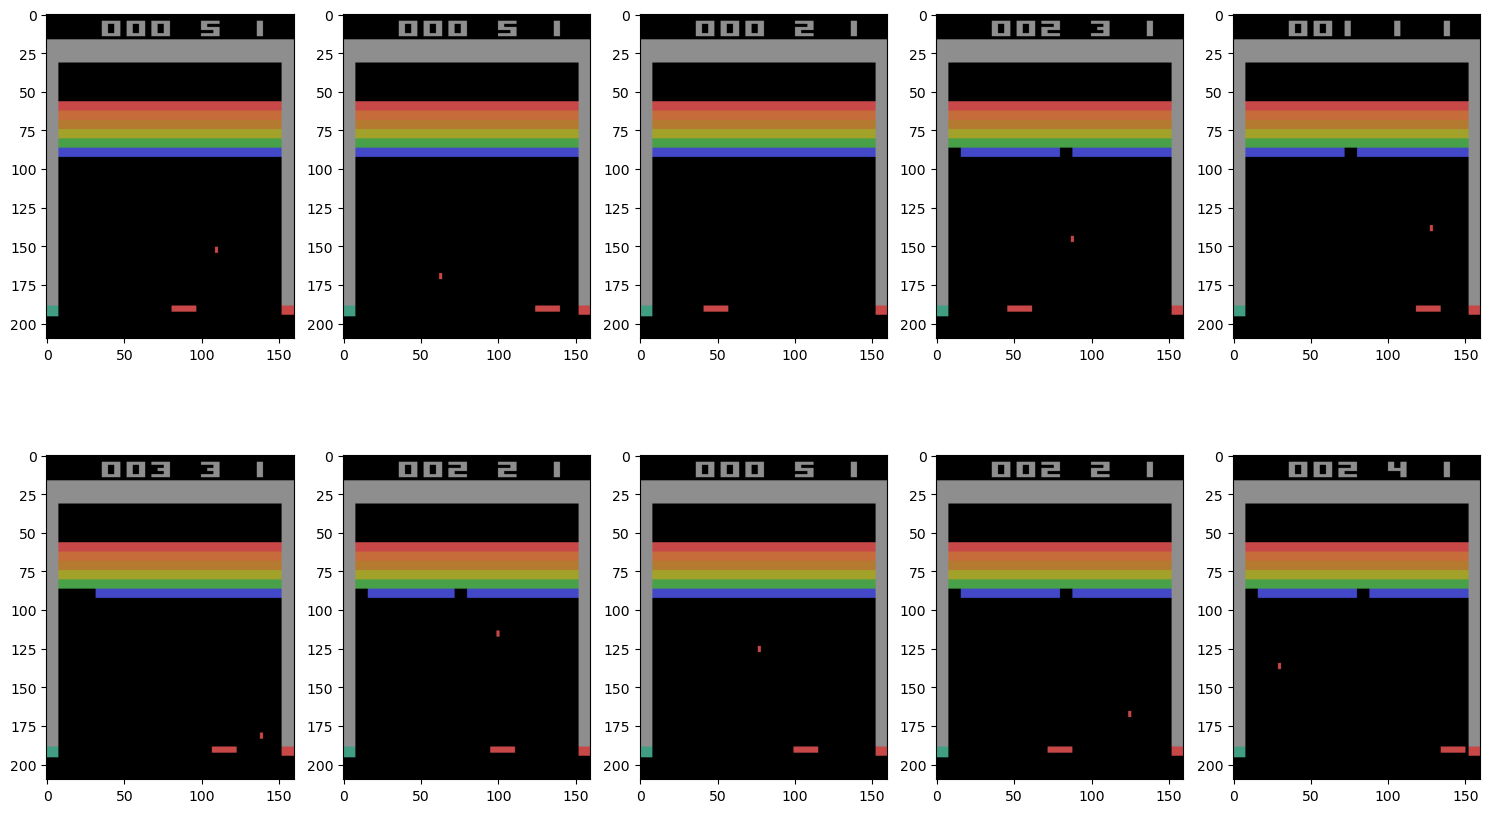

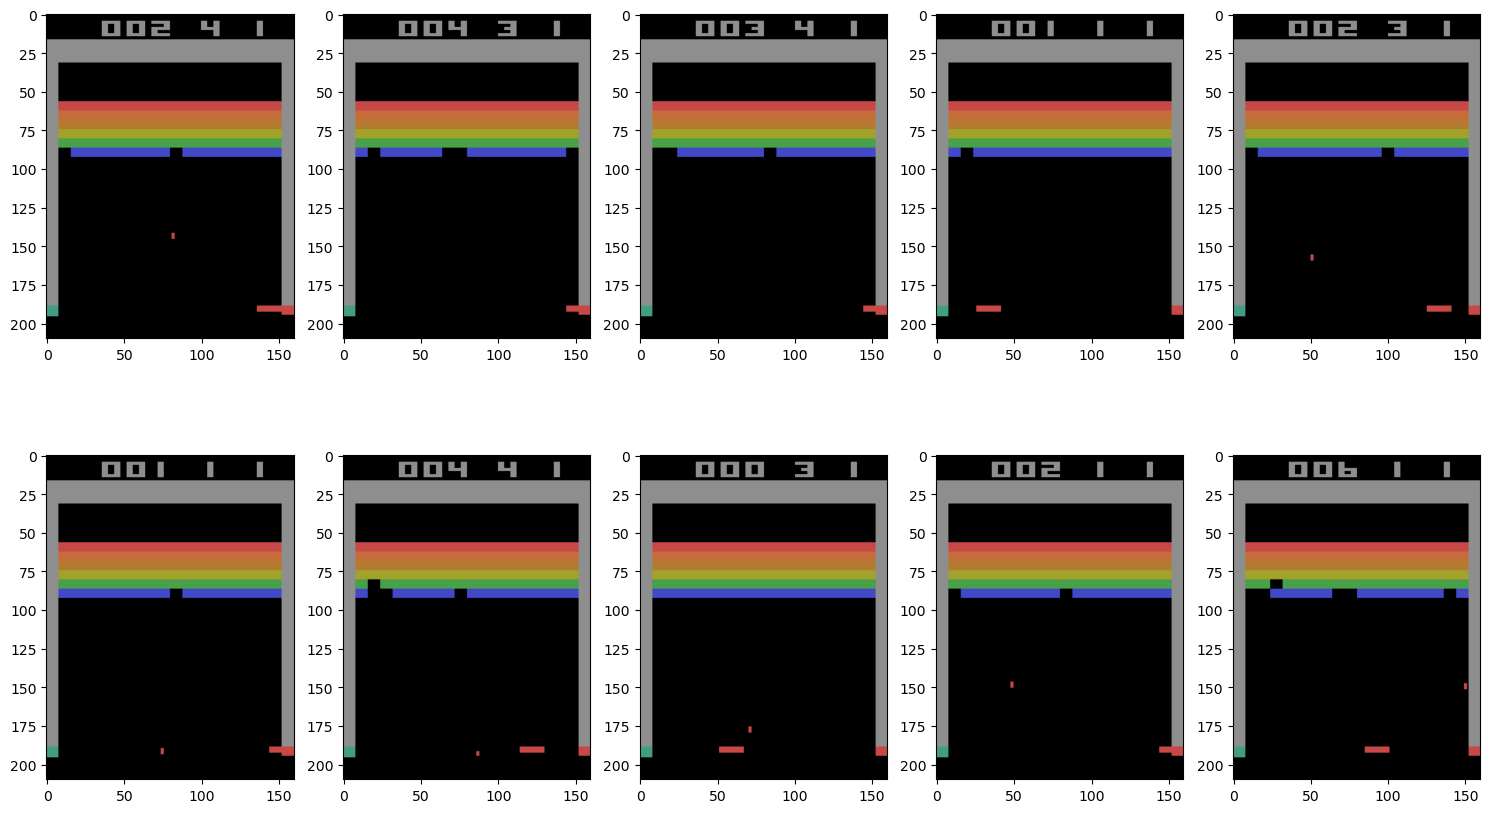

In [5]:
cols=5
rows=2
fig, axs = plt.subplots(rows, cols)
fig.set_size_inches(18.5, 10.5)
samples = test_buffer.sample(cols*rows)[0]
for ax, image in zip(fig.axes, samples):        
    # image = test_buffer.sample(1)[0][0]
    image = image.reshape(210, 160, 3)
    # image = image.permute(2, 0, 1)
    image = image.type(torch.int64)
    ax.imshow(image)

plt.show()

Summary:
1. 500, 0.003 seems to have diverse images, maybe not easy ones
2. 800, 1 maybe difficult but not diverse
3. 800, 0.003 seems to be also good
4. 500, 0.0001 also good maybe a bit further in game state